Análisis de performance de agentes - Búsqueda Local CSP
===

# Tiempo de ejecución

In [1]:
import NQueens
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from time import time_ns

## Se llevará a cabo con la siguiente configuración:

In [2]:
algorithms = [NQueens.backtracking, NQueens.forwardchecking, NQueens.forwardchecking_mrv]
sizes = [4, 8, 10, 12, 15]
n_iterations = 30
random.seed(42)

---

## Correr simulación

In [3]:
def run_simulation(simulations, algorithms, size):
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        start = time_ns()
        _, best_h, iterations = algorithm(size)
        end = time_ns()
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'iterations': iterations,
            'time_ms': (end-start)/1e6
        })

In [4]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in sizes:
        for _ in range(n_iterations):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('attachments/simulations.csv')
simulations_df

,algorithm,size,iterations,time_ms
0,backtracking,4,8,0.124357
1,backtracking,4,8,0.116661
2,forwardchecking,4,8,0.248778
3,forwardchecking,4,8,0.289177
4,forwardchecking_mrv,4,8,0.408174
...,...,...,...,...
445,forwardchecking,15,1026,30.100552
446,forwardchecking_mrv,15,34,1.330524
447,backtracking,15,1359,23.249503
448,forwardchecking,15,1026,17.543963


## Análisis del performance de cada algorítmo

In [5]:
samples_list = []

for algorithm in algorithms:
    for size in sizes:
        sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}" and size == {size}')
        
        # Save saple report
        samples_list.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'time_ms_avg': sample_df['time_ms'].mean(),
            'time_ms_std': sample_df['time_ms'].std(),
            'iter_avg': sample_df['iterations'].mean(),
            'iter_std': sample_df['iterations'].std()
        })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('attachments/samples.csv')
samples_df

,algorithm,size,time_ms_avg,time_ms_std,iter_avg,iter_std
0,backtracking,4,0.087140,0.019835,8.0,0.0
1,backtracking,8,1.346957,0.247356,113.0,0.0
2,backtracking,10,1.539587,0.280194,102.0,0.0
3,backtracking,12,4.690877,0.517696,261.0,0.0
4,backtracking,15,31.335143,3.144146,1359.0,0.0
5,forwardchecking,4,0.227610,0.040173,8.0,0.0
6,forwardchecking,8,2.137864,0.230338,88.0,0.0
7,forwardchecking,10,2.302572,0.254641,83.0,0.0
8,forwardchecking,12,6.825067,1.904779,193.0,0.0
9,forwardchecking,15,37.514088,6.994734,1026.0,0.0


## Gráficos
### Boxplot - Tiempo empleado hasta llegar a una solución

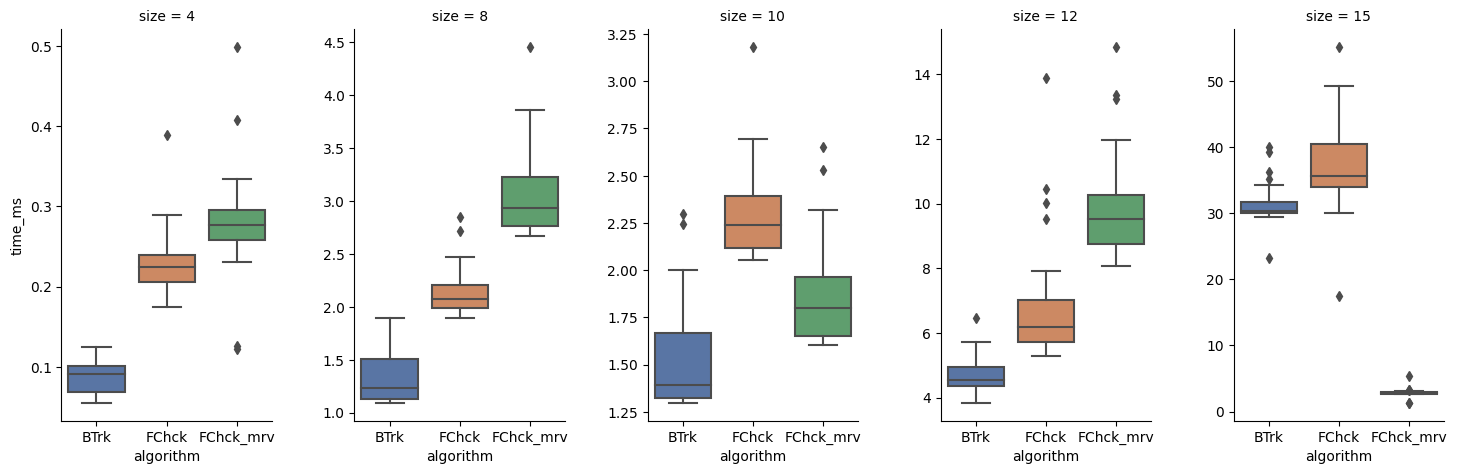

In [6]:
%matplotlib inline

grid1 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid1.map(sns.boxplot, 'algorithm', 'time_ms', order= [x.__name__ for x in algorithms], palette="deep")
grid1.set_xticklabels(['BTrk', 'FChck', 'FChck_mrv'])

grid1.fig.subplots_adjust(top=1.5)
grid1.savefig('attachments/time_by_algorithm.svg')

### Lineplot - Tiempo empleado en función del tamaño


In [7]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in range(4, 25):
        for _ in range(5):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations2_df = pd.DataFrame(list(simulations))
    
simulations2_df

,algorithm,size,iterations,time_ms
0,backtracking,4,8,0.090949
1,backtracking,4,8,0.096645
2,backtracking,4,8,0.112356
3,forwardchecking,4,8,0.311172
4,forwardchecking,4,8,0.329541
...,...,...,...,...
310,backtracking,22,1737188,61387.730524
311,forwardchecking,24,286963,7117.795764
312,forwardchecking_mrv,24,43,3.194629
313,forwardchecking,22,1207239,26744.917099


AttributeError: 'AxesSubplot' object has no attribute 'savefig'

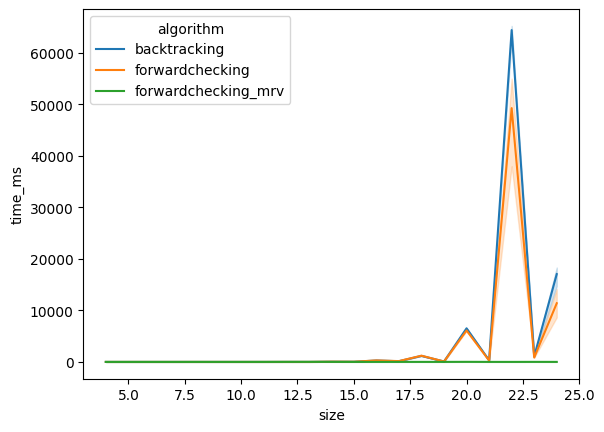

In [8]:
%matplotlib inline

plot2 = sns.lineplot(data=simulations2_df, x='size', y='time_ms', hue='algorithm')
plot2.savefig('attachments/time_by_size_lin.svg')

In [ ]:
%matplotlib inline

plot3 = sns.lineplot(data=simulations2_df, x='size', y='time_ms', hue='algorithm')
plot3.set(yscale='log')
plot3.savefig('attachments/time_by_size_log.svg')